# Geometrical Methods in Machine Learning
## Seminar 3: Intrinsic Dimension Estimation

In [1]:
from __future__ import print_function
import os
%matplotlib inline
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
import numpy as np
from math import pi
from IPython.core.debugger import set_trace
from sklearn.datasets import load_digits, fetch_olivetti_faces
from sklearn.neighbors import NearestNeighbors

### Maximum Likelihood Estimation of Intrinsic Dimension algorithm implementation is taken from the seminar for the course Geometrical Methods of Machine Learning (A. Bernstein, TA O. Kachan), Skoltech, 2020

#### link to the seminar notebook: https://github.com/oleg-kachan/GMML2020/blob/master/seminar3/seminar3_solution.ipynb

## 1. Maximum Likelihood Estimation of Intrinsic Dimension

_Levina, E., & Bickel, P. J. (2005).  
Maximum Likelihood Estimation of Intrinsic Dimension.  
In Advances in Neural Information Processing Systems (pp. 777-784)._

The idea of the nearest-neighbor intrinsic dimension estimation is based on fact of the  that the number of sample points in $\mathbf{X} = \mathbb{R}^n$ falling into a ball around $\mathbf{x}$ is proportional to the radius of of the ball $R$, the dimension of the ball $d$ and the density $f(x)$ for which the well-known estimator exists

$$f(x) = \frac{k/n}{R^d V(d)},$$

where $V(d) = \pi^{d/2} [\Gamma (d/2+1)]^{-1}$ is the volume of unit sphere in $\mathbb{R}^d$ and $\Gamma(d) = (d - 1)!$ is the Gamma function.

Then the intrinsic dimension $d$ of the sample can be regressed out or estimated by the maximum likelihood appoarch.

Consider a dataset $\mathbf{X} \in \mathbb{R}^n$ of intrinsic dimension $d$. Fix a sample point $\mathbf{x} \in \mathbf{X}$. Define $B(\mathbf{x}, t)$ as a ball centered at $\mathbf{x}$ with radius $t$, such that $0 \leq t \leq R$, where $R$ is arbitrary small radius. Consider a random process, which counts the number of observations within a distance $t$ to $\mathbf{x}$

$$N(\mathbf{x}, t) = \sum_n \mathbb{I} \{\| \mathbf{x}_i - \mathbf{x} \| \leq t \} = \#\{\mathbf{x}_i \in B(\mathbf{x}, t) \}.$$

Approximating this (binomial, w/ fixed $n$) random process by a Poisson process and suppressing the dependence on $\mathbf{x}$ for now, we can write the rate $\lambda(t)$ of the Poisson process $N(t)$ as 

$$\lambda(t) = f(\mathbf{x}) \cdot V(d) \cdot d \cdot t^{d-1}.$$

Let $\theta = \log f(x)$ then log-likelihood of the observed process is:

$$L(d, \theta) = \int_{0}^{R} \log \lambda(t) d N(\mathbf{x}, t) - \int_{0}^{R} \lambda(t) dt$$

which should be maximized over parameters $d$ and $\theta$.

Maximum likelihood estimator for dimension $d$ at point $\mathbf{x}$ is:

$$\hat{d}_R(\mathbf{x}) = \left[ \frac{1}{N(\mathbf{x}, R)} \sum_{j=1}^{N(\mathbf{x}, R)} \log \frac{R}{r_j(\mathbf{x})} \right]^{-1}$$

where $r_j = \| \mathbf{x}_j - \mathbf{x} \|, j = 1, 2, \dots$ is the distance to the $j$-th nearest neighbor.

In practice, it may be more convenient to grow the number of neighbors $k$ rather than the radius of the sphere $R$. Let we use $k$ nearest neighbors $\mathbf{x}_1, \dots, \mathbf{x}_n$ of a point $\mathbf{x}$ and $R = \mathbf{x}_k$ then the MLE estimator is:

$$\hat{d}_k(\mathbf{x}) = \left[ \frac{1}{k - 1} \sum_{j=1}^{k - 1} \log \frac{r_k(\mathbf{x})}{r_j(\mathbf{x})} \right]^{-1}$$

Averaging over $\hat{d}_k(\mathbf{x})$ gives the intrinsic dimension of the dataset $\mathbf{X}$.

In [2]:
"""
Implementation of 'Maximum Likelihood Estimation of Intrinsic Dimension' by Elizaveta Levina and Peter J. Bickel
 
how to use
----------
 
The goal is to estimate intrinsic dimensionality of data, the estimation of dimensionality is scale dependent
(depending on how much you zoom into the data distribution you can find different dimesionality), so they
propose to average it over different scales, the interval of the scales [k1, k2] are the only parameters of the algorithm.
 
This code also provides a way to repeat the estimation with bootstrapping to estimate uncertainty.
 
Here is one example with swiss roll :
 
from sklearn.datasets import make_swiss_roll
X, _ = make_swiss_roll(1000)
 
k1 = 10 # start of interval(included)
k2 = 20 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, 
                             mode='bootstrap', 
                             nb_iter=500, # nb_iter for bootstrapping
                             verbose=1, 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
# the shape of intdim_k_repeated is (nb_iter, size_of_interval) where 
# nb_iter is number of bootstrap iterations (here 500) and size_of_interval
# is (k2 - k1 + 1).
 
# Plotting the histogram of intrinsic dimensionality estimations repeated over
# nb_iter experiments
plt.hist(intdim_k_repeated.mean(axis=1))
 
"""
import tqdm
#from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5, neighb=None):
    if neighb is None:
        neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X)
#     print("collected dist, ind")
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    try:
        assert np.all(dist > 0)
    except:
        set_trace()
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample

def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    '''
    step = 5
    '''
    X = pd.DataFrame(X).drop_duplicates() # remove duplicates in case you use bootstrapping
    
    #########################
    # hack to drop all dubl #
    #########################
    pdist = pairwise_distances(X.values)
    pdist = (pdist == 0)
    pdist[np.triu(pdist)] = False
    drop_mask = pdist.sum(1).astype(bool)
    X = X.drop(index=X.index[drop_mask]).values
    ###############################
    
    intdim_k = []
    
    for k in range(k1, k2 + 1, 5):
#         print("calculating neighbours for: " + str(k))
        neighb = NearestNeighbors(n_neighbors=k+1, n_jobs=32).fit(X)
#         print("done")
        m = intrinsic_dim_sample_wise(X, k, neighb).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
    
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

In [3]:
root = './separate_datasets_data'
paths = [os.path.join(root,path) for path in os.listdir(root)]

In [4]:
# check that data is normalized
def check_data(data):
    print(data.shape)
    return all(np.abs(data.sum(1) - 1) < 1e-7)

In [5]:
# sample data with a given fraction via binomial mask
def sample_data(data, fraction):
    mask = np.random.binomial(1, fraction, data.shape[0]).astype(bool)
    return data[mask]

In [6]:
indims = {}
neigh = {}

In [7]:
k1_dict = {}
k2_dict = {}
for p in paths[0:]:
    n_samples = np.genfromtxt(p, delimiter=';').shape[0]
    k1_dict[p] = min(10, n_samples//20)
    k2_dict[p] = min(100, n_samples//4)

In [8]:
# run the algorithm MLE of Intristic dimension
#indims and neigh lists are containing the information about intristic dimension estimators and neighborhood sizes 
# k1 = 10 # start of interval(included)
# k2 = 100 # end of interval(included)
nb_iter = 5

for path in tqdm.tqdm_notebook(paths): 
    print(path)
    d = np.genfromtxt(path, delimiter=';')
    #d = np.unique(np.genfromtxt(path, delimiter=';'), axis = 0)
    #d = sample_data(d, 0.3)
    
    k1 = k1_dict[path]
    k2 = k2_dict[path]

    intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                 d, 
                                 mode='bootstrap', 
                                 #mode = 'shuffle',
                                 nb_iter=nb_iter, # nb_iter for bootstrapping 
                                 k1=k1, k2=k2)
                                 #k1=k1, k2=min(d.shape[1], k2))
                                 #, step=5)
    intdim_k_repeated = np.array(intdim_k_repeated)
    
    neighbors = np.arange(k1, k2, 5)
    #neighbors = np.arange(k1, min(d.shape[1], k2), 5)
    
    indims[path] = intdim_k_repeated
    neigh[path] = neighbors

./separate_datasets_data/ptb_proj_f.csv
./separate_datasets_data/AGP_proj_o.csv
./separate_datasets_data/t2d_proj_f.csv
./separate_datasets_data/ibd_proj_o.csv
./separate_datasets_data/t2d_proj_g.csv
./separate_datasets_data/ptb_proj_g.csv
./separate_datasets_data/ptb_proj_o.csv
./separate_datasets_data/AGP_proj_f.csv
./separate_datasets_data/AGP_proj_g.csv
./separate_datasets_data/ibd_proj_f.csv
./separate_datasets_data/t2d_proj_o.csv
./separate_datasets_data/ibd_proj_g.csv



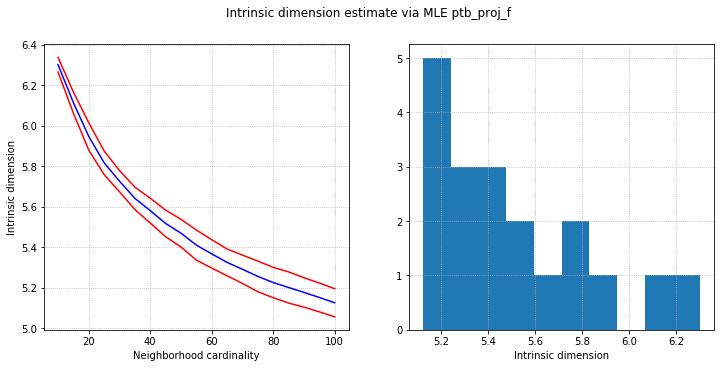

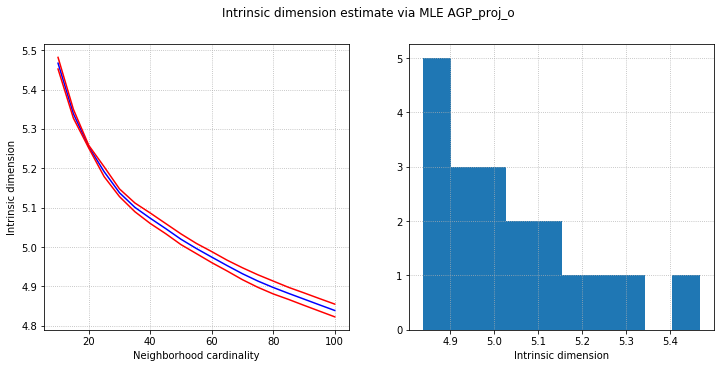

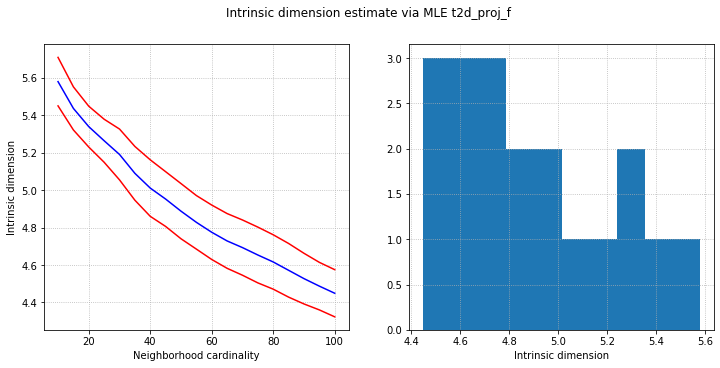

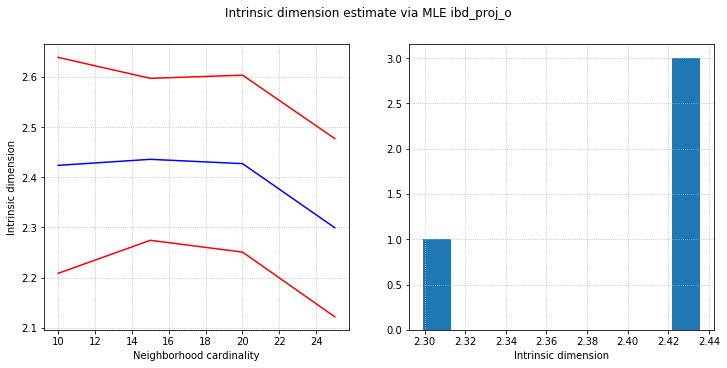

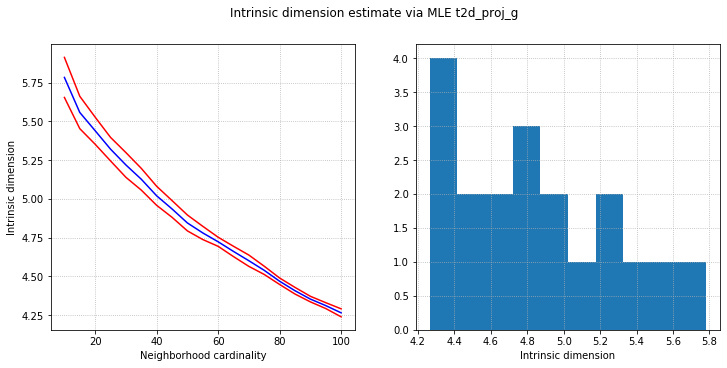

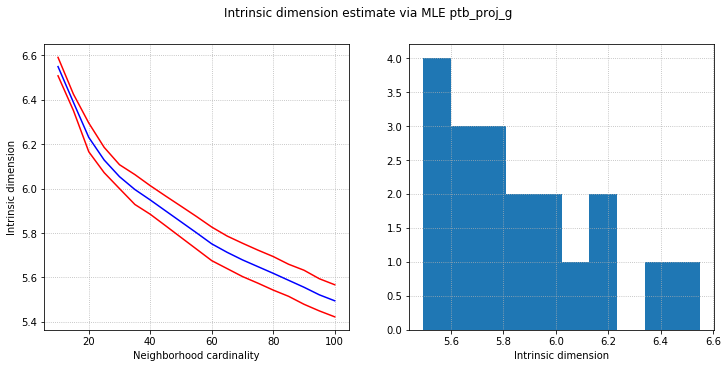

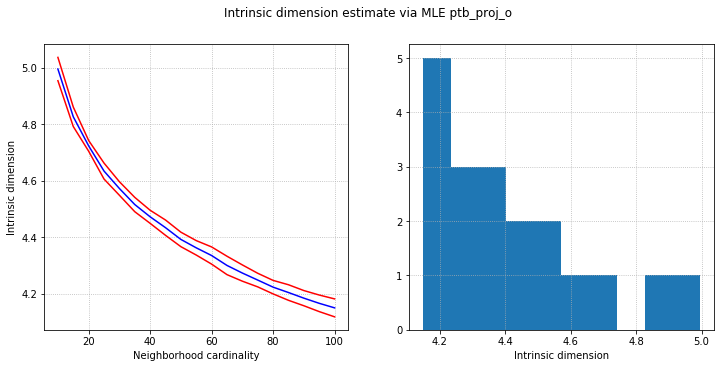

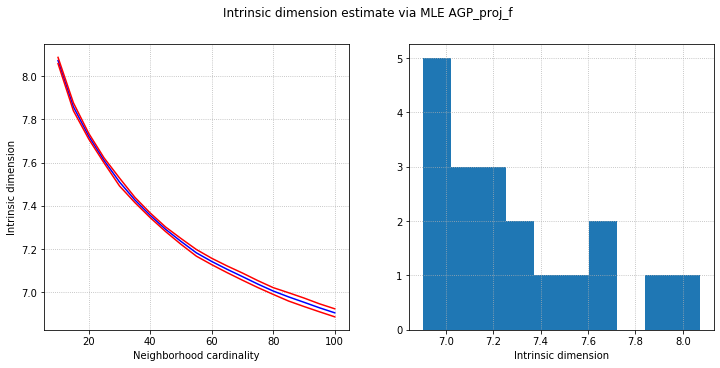

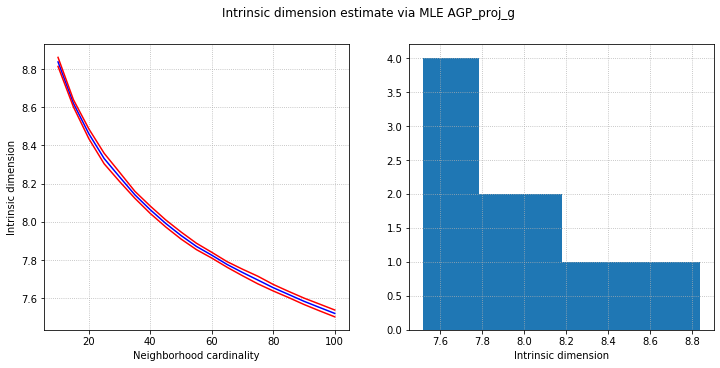

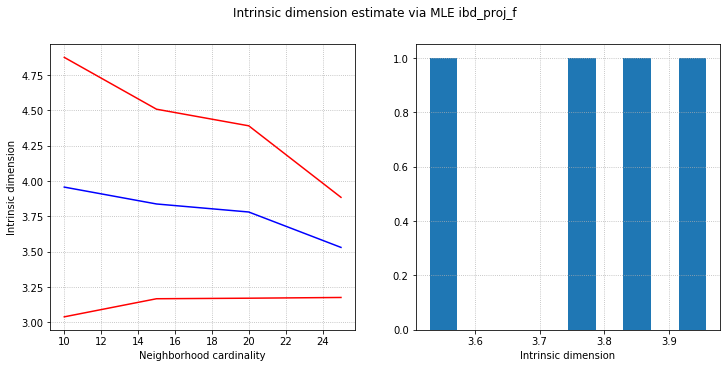

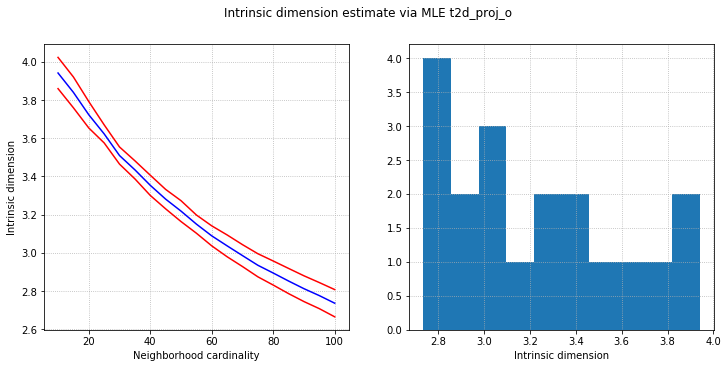

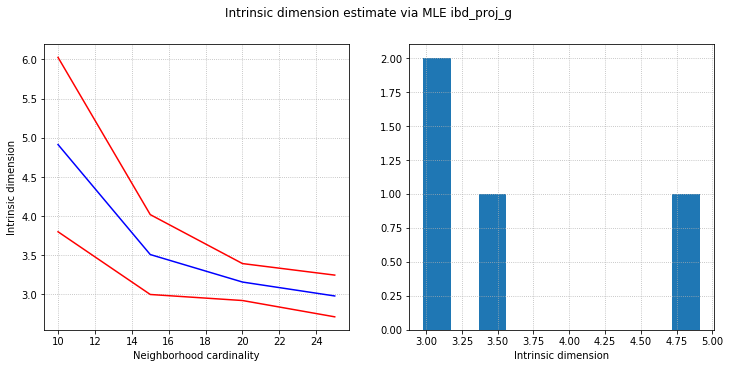

In [18]:
dims = {}
# plotting the result
for k in indims.keys():
    intdim_k_repeated = indims[k]
    neighbors = neigh[k]
    
    fig = plt.figure(figsize=(12,5.25))

    plt.suptitle("Intrinsic dimension estimate via MLE " + k.split("/")[-1].split(".")[0])
    
    floor_n_ceil = np.concatenate((np.floor(np.mean(intdim_k_repeated, axis=0)).astype(int), 
                                    np.ceil(np.mean(intdim_k_repeated, axis=0)).astype(int)))
    dims[k] = np.unique(floor_n_ceil)
    plt.subplot(121)
    plt.xlabel("Neighborhood cardinality")
    plt.ylabel("Intrinsic dimension")
    plt.grid(linestyle='dotted')

    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0), 'b')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0), 'b')
#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

    plt.subplot(122)
    plt.xlabel("Intrinsic dimension")
    plt.grid(linestyle="dotted")

    plt.hist(intdim_k_repeated.mean(axis=0))
    plt.show()

In [28]:
path
s = ''
''.join(path.split("/")[-1].split(".")[0].split('_')[:4])

'ibdprojg'

In [19]:
dims

{'./separate_datasets_data/ptb_proj_f.csv': array([5, 6, 7]),
 './separate_datasets_data/AGP_proj_o.csv': array([4, 5, 6]),
 './separate_datasets_data/t2d_proj_f.csv': array([4, 5, 6]),
 './separate_datasets_data/ibd_proj_o.csv': array([2, 3]),
 './separate_datasets_data/t2d_proj_g.csv': array([4, 5, 6]),
 './separate_datasets_data/ptb_proj_g.csv': array([5, 6, 7]),
 './separate_datasets_data/ptb_proj_o.csv': array([4, 5]),
 './separate_datasets_data/AGP_proj_f.csv': array([6, 7, 8, 9]),
 './separate_datasets_data/AGP_proj_g.csv': array([7, 8, 9]),
 './separate_datasets_data/ibd_proj_f.csv': array([3, 4]),
 './separate_datasets_data/t2d_proj_o.csv': array([2, 3, 4]),
 './separate_datasets_data/ibd_proj_g.csv': array([2, 3, 4, 5])}

In [20]:
np.save('./separate_datasets_data/intrinsic_dims', dims)